# Correlated electron models calculations
In this notebook, we're going to calculate the Hamiltonian matrix for the Heisenberg and Hubbard models on a 4 site 1D chain with periodic boundary conditions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

## Get the pairs of first neighbors

In [2]:
L = 4
first_neighbour_pairs = []
for i in range(L):
    j = (i+1) % L
    if j>i:
        first_neighbour_pairs.append((i, (i+1) % L))

    j = (i-1) % L
    if j>i:   
        first_neighbour_pairs.append((i, (i-1) % L))


In [3]:
first_neighbour_pairs

[(0, 1), (0, 3), (1, 2), (2, 3)]

## Heisenberg model
The Hamiltonian is: 

$$\mathcal{\hat H} = J \sum_{\langle ij \rangle} \hat S_i \cdot \hat S_j$$
First let's write some helpful functions to implement the Pauli matrices on the pairs of neighbors. 

In [4]:
def zizj(N,i,j):
    """This functions returns the product of spins on sites i and j, +/- 1"""
    si, sj = (N>>i)&1, (N>>j)&1
    return (si-0.5)*(sj-0.5)


def xixj(N,i,j):
    """This function flips the spin on sites i and j and returns the new state."""
    mask = (1<<i) | (1<<j)
    return 0.25, N^mask

def yiyj(N,i,j):
    """This function returns the product of spins on sites i and j and returns the new state
    from flipping the spins on sites i and j."""
    si, sj = (N>>i)&1, (N>>j)&1
    mask = (1<<i) | (1<<j)
    return -(si-0.5)*(sj-0.5), N^mask

To construct the Hamiltonian, we create an empty array of size $2^L \times 2^L$ and fill the matrix by applying each operator to each state of the basis in a for loop. 

In [5]:
basis_heis = np.arange(2**L) # all possible states
Hheis = np.zeros((2**L,2**L)) # Hamiltonian matrix, empty for now

for N in basis_heis: #loop through all possible states
    for i,j in first_neighbour_pairs: #loop through all first neighbour pairs
        
        #ZiZj
        Hheis[N,N] += zizj(N,i,j) #add the interaction term to the diagonal

        #XiXj
        mel, N2 = xixj(N,i,j)
        Hheis[N2,N] += mel #add the interaction term to the off-diagonal

        #YiYj
        mel, N2 = yiyj(N,i,j)
        Hheis[N2,N] += mel #add the interaction term to the off-diagonal


In [19]:
E,psi = np.linalg.eigh(Hheis) #diagonalize the Hamiltonian
x,y = np.unique(np.round(E,5), return_counts=True)

[1 3 7 5]


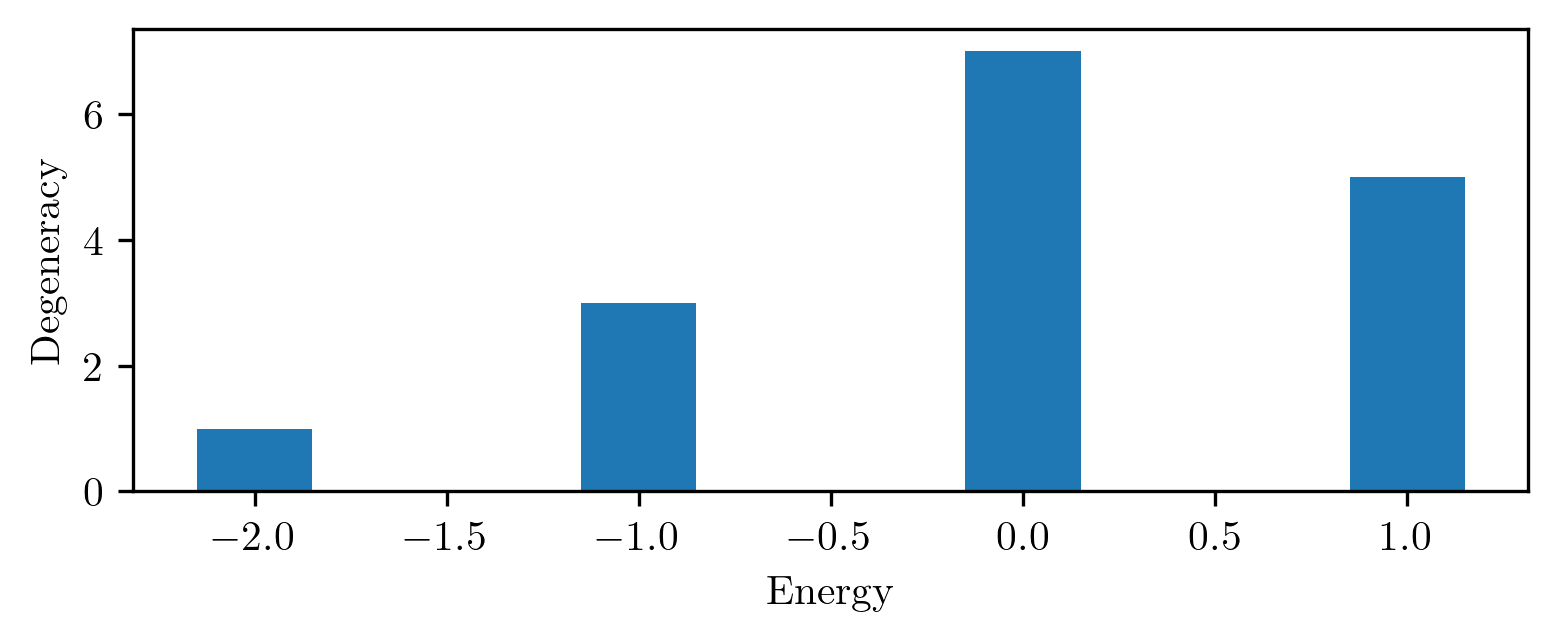

In [24]:
plt.figure(figsize=(6,2))
plt.bar(x,y, width=0.3)
plt.xlabel('Energy')
plt.ylabel('Degeneracy')
plt.savefig('figures/heis4E.pdf')

## Hubbard model
The Hamiltonian is: 

$$\mathcal{\hat H} = -t \sum_{\langle ij \rangle, \sigma} \hat c^\dag_{i\sigma} \hat c_{j\sigma} + \hat c^\dag_{j\sigma} \hat c_{i\sigma} + \sum_{i=0}^{L-1} \hat n_{i\uparrow} \hat n_{i\downarrow}.$$
Let's write the functions that implement these operators. Recall that the creation and annihilation operators anticommute, so we need to worry about the sign when implementing the hopping terms. 

Helpful functions

In [7]:
def n(N,i,spin):
    """returns the eigenvalue for the number operator for spin sigma on site i
    either 0 or 1."""

    return (N>>(i+L*spin))&1


def phase(N,i,j,spin):
    """returns the phase for the creation operator c^dagger_i c_j +/-1"""

    parity = sum([(N>>(l+L*spin))&1 for l in range(min(i,j)+1,max(i,j))])%2
    return (-1)**parity


def checkcdagc(N,i,j,spin):
    """returns True if the hopping is possible, False otherwise"""

    if n(N,j,spin) - n(N,i,spin) ==1:
        return True
    else:
        return False


def cdagc(N,i,j,spin):
    """Returns a new state with a particle created on site i and destroyed on site j as well as the phase, 
    assumes that check is True."""

    p = phase(N,i,j,spin)
    mask = (1<<(i+L*spin)) | (1<<(j+L*spin))
    N = N^mask
    return p, N

To construct the Hamiltonian, we use the same process than before, construct an empty $4^L \times 4^L$ matrix and fill it up by looping
through basis and applying each operator to each basis state. 

In [8]:
basis_hubbard = np.arange(4**L) # all possible states
Hhub = np.zeros((4**L,4**L)) # Hamiltonian matrix, empty for now
down,up = 0,1 #spin indices


for N in basis_hubbard: #loop through all possible states


    for i in range(L): #on site interaction term
        Hhub[N,N] += n(N,i,up)*n(N,i,down) #on site interaction 


    for i,j in first_neighbour_pairs: #loop through all first neighbour pairs
        
        
        #Hopping spin up 
        if checkcdagc(N,i,j,up):
            p, N2 = cdagc(N,i,j,up)
            Hhub[N2,N] += -p

        #Hopping spin up h.c
        if checkcdagc(N,j,i,up):
            p, N2 = cdagc(N,j,i,up)
            Hhub[N2,N] += -p

        
        #Hopping spin down 
        if checkcdagc(N,i,j,down):
            p, N2 = cdagc(N,i,j,down)
            Hhub[N2,N] += -p

        #Hopping spin down h.c
        if checkcdagc(N,j,i,down):
            p, N2 = cdagc(N,j,i,down)
            Hhub[N2,N] += -p

        


## Plotting 

That's it! Let's plot a heatmap of our three Hamiltonian matrices and see what we get..

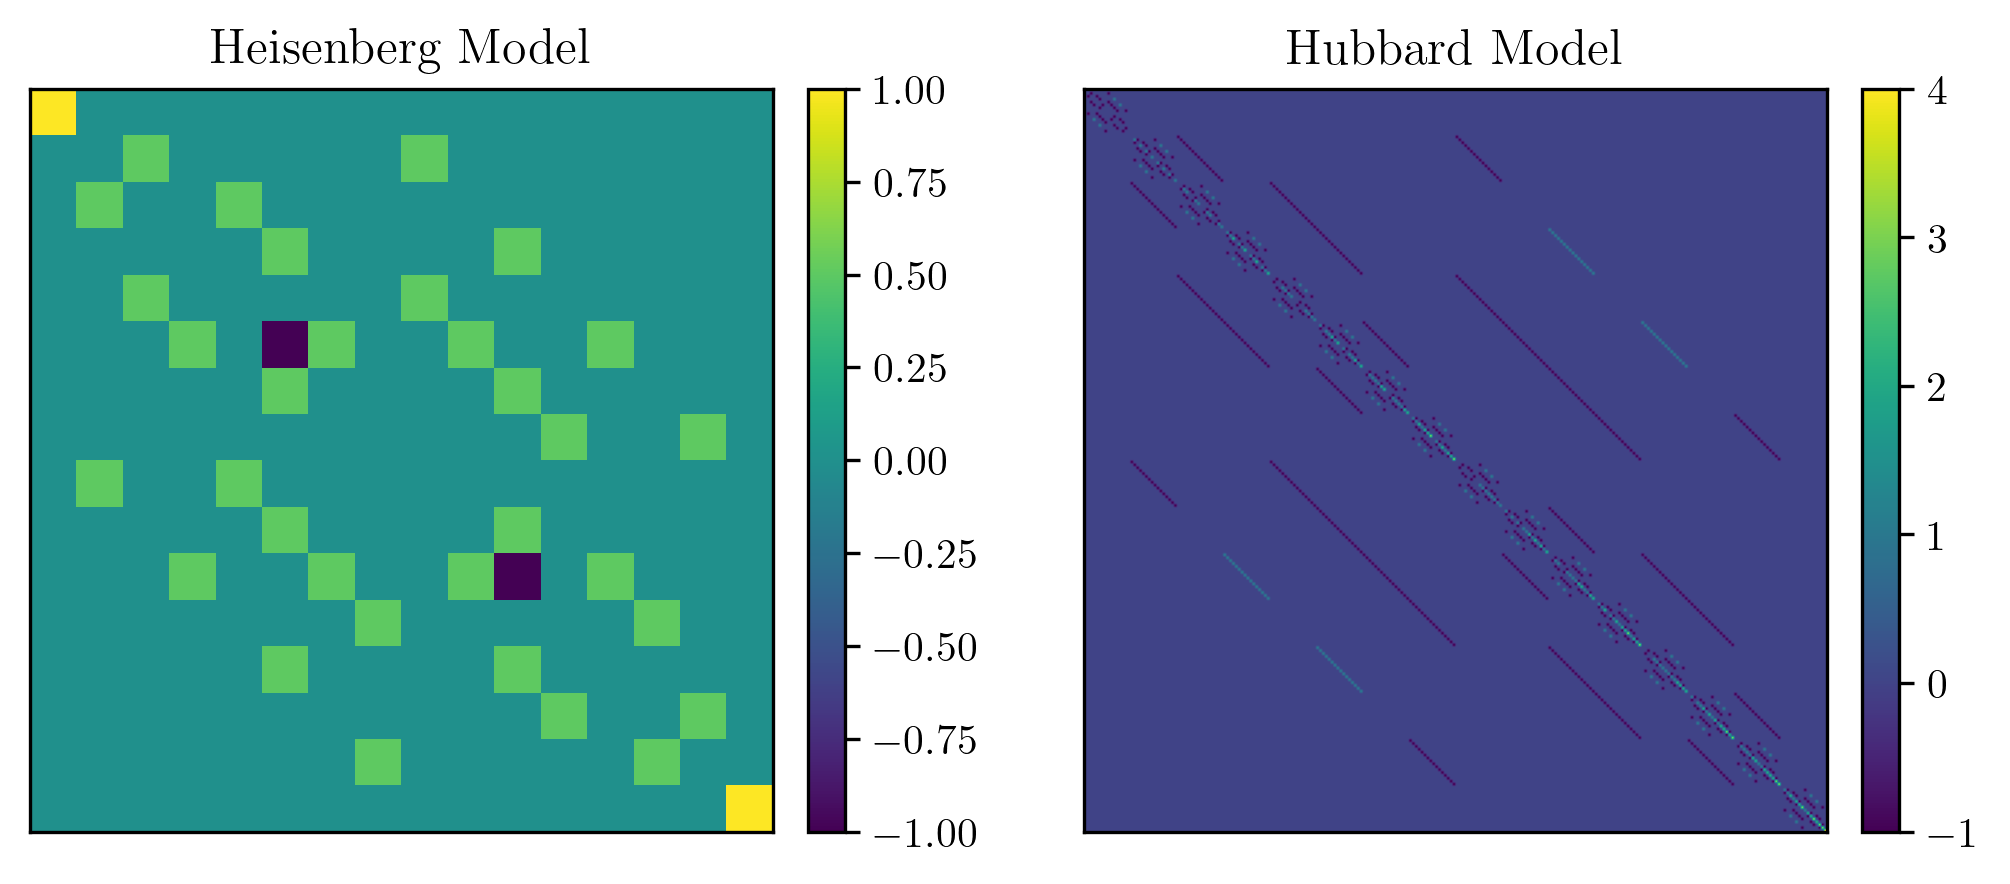

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

# Plot Hheis
im0 = axs[0].imshow(Hheis, cmap='viridis', aspect='equal')
axs[0].set_title('Heisenberg Model', fontsize=12)
cbar0 = fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# Plot Hhub
im1 = axs[1].imshow(Hhub, cmap='viridis', aspect='equal')
axs[1].set_title('Hubbard Model', fontsize=12)
cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# Remove xticks and yticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig('./figures/hamiltonians.pdf', format='pdf')
plt.show()
